In [1]:
import pandas as pd
import geopandas as gpd
import sys, os
from os.path import join, expanduser, basename
from shapely.geometry import Point
from folium import plugins
import folium as flm
import rasterio as rio
from rasterio.plot import show

In [2]:
sys.path.append(join(expanduser("~"), 'Repos', 'GOSTrocks', 'src'))
import GOSTrocks.rasterMisc as rMisc

In [3]:
acled = pd.read_csv('../../data/Niger_conflict_data.csv')

In [4]:
acled.loc[:, "geometry"] = acled.apply(lambda x: Point(x.longitude, x.latitude), axis=1)

In [5]:
acled = gpd.GeoDataFrame(acled, geometry='geometry', crs='EPSG:4326')

In [6]:
len(acled)

3485

In [7]:
acled.year.value_counts()

year
2022    982
2023    795
2020    550
2021    431
2019    371
2024    356
Name: count, dtype: int64

In [8]:
acled.civilian_targeting.value_counts()

civilian_targeting
Civilian targeting    1473
Name: count, dtype: int64

In [9]:
# map = folium.Map(location=[15, 30], tiles="Cartodb dark_matter", zoom_start=2)
# heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]
# heat_data
# plugins.HeatMap(heat_data).add_to(map)

In [10]:
acled_filt = acled.loc[acled['year']==2023].copy()
# acled_filt = acled.loc[(acled['year']==2023) & (acled['civilian_targeting'] == "Civilian targeting")].copy()

In [11]:
acled_filt.loc[:, "fatalities_norm"] = ((acled_filt.fatalities-acled_filt.fatalities.min())/(acled_filt.fatalities.max()-acled_filt.fatalities.min()))

In [12]:
# acled_filt.loc[acled_filt.fatalities==15]

In [13]:
heat_data = [[row.geometry.xy[1][0], row.geometry.xy[0][0], row.fatalities_norm] for idx, row in acled_filt.iterrows()]
# heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

In [14]:
# plugins.HeatMap?

In [15]:
# m = flm.Map()
# plugins.HeatMap(heat_data).add_to(m)
# flm.LayerControl().add_to(m)
# m

In [16]:
data_dir = join(expanduser('~'), 'data', 'niger')

In [40]:
evi = join(data_dir, 'zcore_dea_2023_09_v1.tif')

In [24]:
# src = rio.open(evi)
# src.meta

In [25]:
len(acled_filt), len(acled)

(795, 3485)

In [26]:
acled_filt = acled_filt.to_crs("EPSG:32632")

In [27]:
acled_filt.loc[:, "geometry"] = acled_filt.geometry.buffer(10000)

In [28]:
# acled_filt.head(100).explore()

In [29]:
import numpy as np

In [30]:
res = rMisc.rasterizeDataFrame(
    inD=acled_filt,
    outFile=None,
    # outFile=join(data_dir, 'acled_rast.tif'),
    idField='fatalities',
    templateRaster=evi,
    mergeAlg='ADD',
    nodata=0
)

In [31]:
vals = res['vals']

In [32]:
vals.max()

175.0

In [47]:
acled_filt.loc[:, "bool"] = 1

In [48]:
res = rMisc.rasterizeDataFrame(
    inD=acled_filt,
    outFile=None,
    # outFile=join(data_dir, 'acled_rast.tif'),
    idField='bool',
    templateRaster=evi,
    mergeAlg='ADD',
    nodata=0
)

In [49]:
vals_count = res['vals']

In [50]:
vals_count.max()

53.0

In [51]:
# np.nanmax(vals)

In [52]:
# vals[vals==0] = np.nan

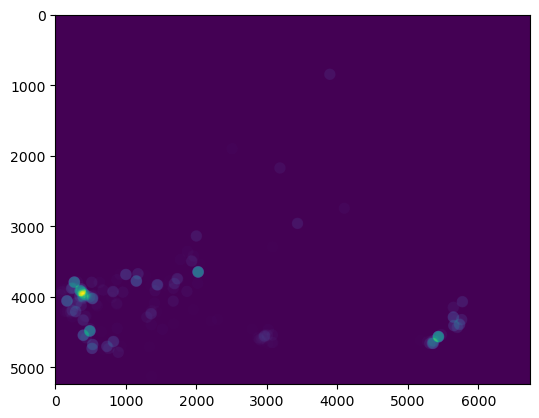

<Axes: >

In [53]:
show(vals)

In [54]:
src = rio.open(evi)
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 6727,
 'height': 5242,
 'count': 1,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(250.0, 0.0, -466208.4527382861,
        0.0, -250.00000000000006, 2618178.8511287076)}

In [55]:
data = src.read(1)

In [56]:
np.nanmax(data), np.nanmin(data)

(17.207535, -7.7767906)

In [57]:
data.flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [58]:
vals.flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [59]:
# indices = list(np.ndindex(data.shape))
# xys = [Point(src.xy(ind[0], ind[1])) for ind in indices]

In [61]:
res_df = pd.DataFrame({
    # 'spatial_index': indices, 
    # 'xy': xys, 
    'evi': data.flatten(),
    'acled': vals.flatten(),
    'acled_count': vals_count.flatten()
})
res_df['pointid'] = res_df.index

In [62]:
df = res_df.loc[~res_df.evi.isna()].copy()

In [66]:
# df.loc[:, "acled"] = df.acled.fillna(0)

In [68]:
df.to_csv('../../data/evi_conflict.csv')

In [120]:
# gdf = gpd.GeoDataFrame(df.head(100), geometry="xy", crs="EPSG:32632")

In [121]:
df.head()

,evi,acled,pointid
2764235,0.569313,0.0,2764235
5004061,-0.032612,0.0,5004061
5004062,0.379615,0.0,5004062
5010786,-0.538359,0.0,5010786
5010787,0.399906,0.0,5010787


In [122]:
# bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
# bin_labels = ['< -2', '(-2, -1]', '(-1, -0.5]', '(-0.5, -0.5]', '(0.5, 1]', '(1, 2]', '> 2']
bins = [-20, -2, -1, 1, 2, 20]
bin_labels = ['< -2', '(-2, -1]', '(-1, 1]', '(1, 2]', '> 2']

df.loc[:, 'zscore_bin'] = pd.cut(df['evi'], bins=bins, include_lowest=True, labels=bin_labels)

In [123]:
df.groupby('zscore_bin')['acled'].mean()

/tmp/ipykernel_3276933/2267268394.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('zscore_bin')['acled'].mean()


zscore_bin
< -2        0.362306
(-2, -1]    0.354791
(-1, 1]     0.468018
(1, 2]      1.020864
> 2         1.278801
Name: acled, dtype: float32

In [81]:
df.groupby('zscore_bin')['acled'].mean()

/tmp/ipykernel_3276933/2267268394.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('zscore_bin')['acled'].mean()


zscore_bin
< -2        0.367628
(-2, -1]    0.360267
(-1, 1]     0.426285
(1, 2]      0.890144
> 2         1.329012
Name: acled, dtype: float32

In [83]:
df['evi'].corr(df['acled'])

0.06723025296333299

In [84]:
import xarray

ModuleNotFoundError: No module named 'xarray'

In [ ]:
%%time
import folium as flm
from os.path import join, expanduser
import numpy as np
import leafmap.foliumap as leafmap
import rasterio as rio
from rasterio import features
from shapely.geometry import box
from affine import Affine
from matplotlib import cm
from rasterio import warp

data_dir = join(expanduser('~'), 'data', 'niger')

m = leafmap.Map()
dest_crs = 'EPSG:4326'

for year in range(2022, 2024):
    src = rio.open(join(data_dir, f'zcore_dea_{year}_09.tif'))
    data = src.read(1)
    
    left, bottom, right, top = src.bounds
    left, bottom, right, top = warp.transform_bounds(src_crs=src.crs, dst_crs=dest_crs, left=left, 
                                   bottom=bottom, right=right, top=top)
    bounds = [[bottom, left], [top, right]]
    
    flm.raster_layers.ImageOverlay(
        image=data,
        name=f'{year}',
        opacity=1,
        bounds=bounds,
        interactive=False,
        cross_origin=False,
        zindex=1,
        colormap=cm.get_cmap('BrBG', 10)
    ).add_to(m)

m.set_center(lon=centx, lat=centy, zoom=6)
m.add_layer_control()
# flm.LayerControl().add_to(m)
m